<a href="https://colab.research.google.com/github/JordanFoss/STAT3007_Project/blob/main/Conv_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
!git clone https://github.com/JordanFoss/STAT3007_Project.git
%cd STAT3007_Project/

Cloning into 'STAT3007_Project'...
remote: Enumerating objects: 4042, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 4042 (delta 143), reused 197 (delta 58), pack-reused 3722
Receiving objects: 100% (4042/4042), 682.53 MiB | 29.80 MiB/s, done.
Resolving deltas: 100% (728/728), done.
Checking out files: 100% (2861/2861), done.
/content/STAT3007_Project/STAT3007_Project


In [46]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
import scipy
import numpy as np
import librosa
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable
import pandas as pd
import glob
import os
from librosa import display
from torchsummary import summary

from IPython.display import Audio

In [47]:
!pip install colorednoise as cn

In [48]:
import pre_process
import data_loading
import CNN_Model
from data_loading import *

In [49]:
X,y = data_loading.load_samples(os.getcwd())

In [50]:
X = torch.tensor(X)
X = X.reshape(X.shape[0],1,X.shape[1],X.shape[2])
y = torch.tensor(y)

In [51]:
X.shape

torch.Size([480, 1, 128, 63])

In [52]:
# RNN combined with CNN
class LRCN(nn.Module):
    def __init__(self, CNN, shape = (24,32,3)):
        super(LRCN, self).__init__()

        self.cnn = CNN
        self.shape = shape

        channel, freq, times = shape
        self.lstm_layers = nn.LSTM(freq*channel*times,256,num_layers = 2, bidirectional = True)
        self.linear = nn.Sequential(nn.Linear(256*2, 5))
        self.flatten = nn.Flatten()

    def forward(self, x, step_size = 21, use_cuda = False):

      if use_cuda:
        h_t = torch.zeros(4,x.shape[0] ,256, dtype=torch.float).to(x.device)
        c_t = torch.zeros(4,x.shape[0], 256, dtype=torch.float).to(x.device)

      else:
        h_t = torch.zeros(4,x.shape[0], 256, dtype=torch.float)
        c_t = torch.zeros(4,x.shape[0], 256, dtype=torch.float)
      
      look_ahead_time = 21
      for current_time in range(0,x.shape[-1], step_size):

        x_t = x[:,:,:,current_time:current_time+look_ahead_time]
        conv_x = self.cnn(x_t)

        conv_x_flat =  self.flatten(conv_x)

        conv_x_flat = conv_x_flat.reshape(1,conv_x_flat.shape[0],conv_x_flat.shape[1])

        output, (h_t, c_t) = self.lstm_layers(conv_x_flat, (h_t, c_t))

      decision_vec = self.linear(output[0])
      return decision_vec

In [53]:
def train_model(data_train, 
                data_test, 
                net, loss, 
                nepoch , 
                lr = 0.01, 
                batch_size = -1, 
                momentum = 0,
                use_cuda = False, 
                print_output = True, 
                optimiser = 'SGD'):

  # setting up arrays for recording
  test_acc = []
  avg_acc = []

  test_loss = []
  avg_loss = []
  # appropriate data type for CPU or GPU
  device = None
  if use_cuda and torch.cuda.is_available():
    dtype = torch.cuda.FloatTensor
    device = torch.device("cuda")
    net = net.to(device)
  else:
    dtype = torch.FloatTensor

  if optimiser == 'SGD':
    optimizer = optim.SGD(net.parameters(), lr = lr, momentum = momentum)
  else:
    optimizer = optim.Adam(net.parameters(), lr = lr, momentum = momentum)
  data_train = data_train.change_type(dtype)
  data_test = data_test.change_type(dtype)

  X_test,y_test = data_test.get_data()

  y_test = y_test.type(torch.LongTensor)
  if device != None:
    y_test = y_test.type(torch.cuda.LongTensor)

  data_loader = DataLoader(data_train, batch_size = batch_size, shuffle = True)

  for epoch in range(nepoch):
    batch_acc = []
    batch_loss = []
    for X_batch, y_batch in data_loader:
      

      y_batch = y_batch.type(torch.LongTensor)
      if use_cuda and device != None:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        y_batch = y_batch.type(torch.cuda.LongTensor)

        

      optimizer.zero_grad()


      pred = net(X_batch, use_cuda = use_cuda)
      Rn = loss(pred, y_batch)
      accur = CNN_Model.accuracy(pred,y_batch)

      batch_acc.append(accur)
      batch_loss.append(Rn.to(torch.device('cpu')).detach().numpy())

      Rn.backward()
      optimizer.step()


    avg_batch_loss = np.mean(batch_loss)
    avg_batch_acc = np.mean(batch_acc)
    avg_acc.append(avg_batch_acc)
    avg_loss.append(avg_batch_loss)

    pred = net(X_test, use_cuda = use_cuda)
    Rn = loss(pred, y_test)
    accur = CNN_Model.accuracy(pred,y_test)
    test_acc.append(accur)
    test_loss.append(Rn.to(torch.device('cpu')).detach().numpy())


    if print_output:
      print('epoch:', epoch)
      print('loss:',Rn.item())
      print('------------')
    

  print('final loss:', Rn.item())

  return net, avg_loss, avg_acc, test_loss, test_acc

In [54]:
data_sets = data_loading.load_sets(X,y,train_ratio=[0.8], seed = [10])
data_train, data_test = data_sets[0]

In [55]:
loss = nn.CrossEntropyLoss()

# Hyperparameter tuning
* random seed = 69
* Optimiser: SGD
* lr: 0.01
* epoch number: 40 
* momentum: 0.2

KeyboardInterrupt: ignored

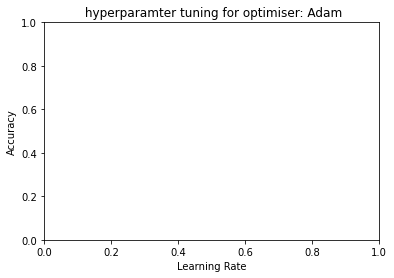

In [56]:
# hyperparameter tuning for optimiser, lr and nepoch
epoch = [i for i in range(10, 51,10)]
fig = plt.figure()
loss = nn.CrossEntropyLoss()
optimiser = 'Adam'
plt.title(' hyperparamter tuning for optimiser: ' + optimiser)
plt.ylabel('Accuracy')
plt.xlabel('Learning Rate')

for nepoch in epoch:

  lrs = [i * 0.001 for i in range(1, 11)]
  acc = []
  for lr in lrs:
    torch.manual_seed(69)
    CNN = CNN_Model.ConvNet()
    conv_LSTM = LRCN(CNN)
    trained_net = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch , batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = 'SGD')
    X_test, y_test = data_test.get_data()
    trained_net = trained_net.to(torch.device('cpu'))
    pred = trained_net(X_test)
    accur = CNN_Model.accuracy(pred,y_test)
    acc.append(accur)
  
  plt.plot(lrs,acc, label = 'epoch = ' + str(nepoch))

plt.legend()

final loss: 0.7707245945930481
final loss: 0.7741596698760986
final loss: 0.7580082416534424
final loss: 0.8585305213928223
final loss: 1.0053373575210571
final loss: 0.8399456143379211
final loss: 0.9833918213844299
final loss: 0.9600781798362732


No handles with labels found to put in legend.


final loss: 1.490085244178772


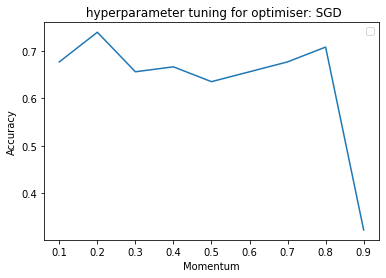

In [ ]:
momentums = [i*0.1 for i in range(1,10)]
acc = []
fig = plt.figure()
loss = nn.CrossEntropyLoss()
optimiser = 'SGD'
plt.title(' hyperparameter tuning for optimiser: ' + optimiser)
plt.ylabel('Accuracy')
plt.xlabel('Momentum')
nepoch = 40
lr = 0.01

for momentum in momentums:

  torch.manual_seed(69)
  CNN = CNN_Model.ConvNet()
  conv_LSTM = LRCN(CNN)
  trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = 'SGD')
  X_test, y_test = data_test.get_data()
  trained_net = trained_net.to(torch.device('cpu'))
  pred = trained_net(X_test)
  accur = CNN_Model.accuracy(pred,y_test)
  acc.append(accur)
  
plt.plot(momentums,acc)

# Final train/test graph

In [57]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)
CNN = CNN_Model.ConvNet()
conv_LSTM = LRCN(CNN)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(data_train, data_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 0.7901762127876282


In [61]:
X_test,y_test = data_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = CNN_Model.classification(pred)

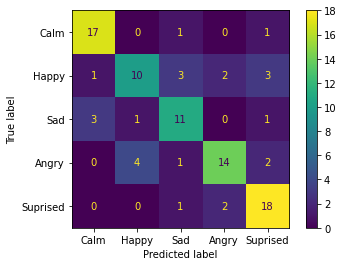

In [65]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot()

In [ ]:
final_array = np.array([avg_loss,test_loss,avg_acc,test_acc])
np.save('/content/drive/MyDrive/STAT3007_project/CNN_Models_Results/CNN_LSTM_Clean.npy',final_array)

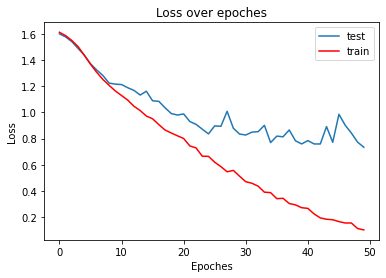

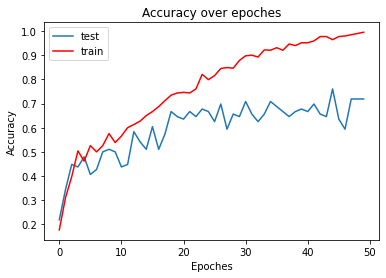

In [ ]:
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()


# NOISY

In [66]:
#Import all the noisy data
noisy_data_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_train_snr40.npy')
noisy_data_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/noisy_test_snr40.npy')
noisy_targets_train = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_train_snr40.npy')
noisy_targets_test = np.load('/content/drive/MyDrive/STAT3007_project/train_test_split_snr40/target_test_snr40.npy')

noisy_data_train = noisy_data_train.reshape(noisy_data_train.shape[0],1,noisy_data_train.shape[1],noisy_data_train.shape[2])
noisy_data_test = noisy_data_test.reshape(noisy_data_test.shape[0],1,noisy_data_test.shape[1],noisy_data_test.shape[2])

noisy_data_train = torch.tensor(noisy_data_train)
noisy_data_test = torch.tensor(noisy_data_test)

#noisy_data = torch.tensor(noisy_data).reshape(noisy_data.shape[0],1,noisy_data.shape[1],noisy_data.shape[2])
noisy_targets_train = torch.tensor(noisy_targets_train)
noisy_targets_test = torch.tensor(noisy_targets_test)

In [67]:
noisy_data_train.shape

torch.Size([6880, 1, 128, 63])

In [68]:
noisy_train = data_loading.DatasetWrapper(noisy_data_train,noisy_targets_train)
noisy_test = data_loading.DatasetWrapper(noisy_data_test,noisy_targets_test)

In [69]:
# hyperparameters:
nepoch = 50
lr = 0.01
momentum = 0.2
optimiser = 'SGD'
loss = nn.CrossEntropyLoss()

torch.manual_seed(69)
CNN = CNN_Model.ConvNet()
conv_LSTM = LRCN(CNN)
trained_net,avg_loss, avg_acc, test_loss, test_acc = train_model(noisy_train, noisy_test, conv_LSTM, loss, nepoch=nepoch, momentum = momentum ,batch_size = 10,lr = lr, use_cuda = True, print_output = False, optimiser = optimiser)

final loss: 2.4329192638397217


In [70]:
X_test,y_test = noisy_test.get_data()
trained_net = trained_net.to(torch.device('cpu'))
pred = trained_net(X_test)
y_pred = CNN_Model.classification(pred)

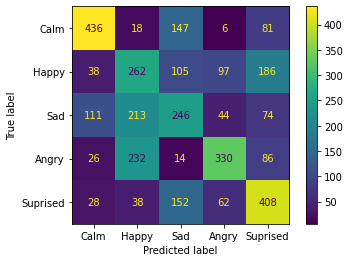

In [73]:
import sklearn
labels = ['Calm', 'Happy', 'Sad', 'Angry', 'Suprised']
confusion = sklearn.metrics.confusion_matrix(y_test.detach().numpy(), y_pred)
thing = sklearn.metrics.ConfusionMatrixDisplay(confusion, display_labels=labels)
thing.plot(values_format = '.5g')

In [ ]:
final_array = np.array([avg_loss,test_loss,avg_acc,test_acc])
np.save('/content/drive/MyDrive/STAT3007_project/CNN_Models_Results/CNN_LSTM_Noisy.npy',final_array)

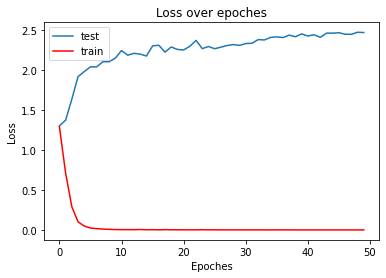

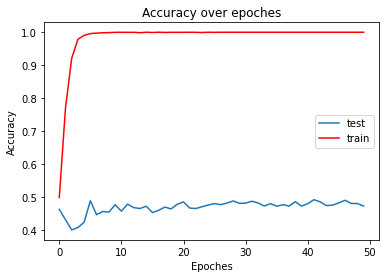

In [ ]:
epoches = [i for i in range(nepoch)]

fig = plt.figure()
plt.plot(epoches,test_loss, label = 'test')
plt.plot(epoches,avg_loss, label = 'train', color = 'r')
plt.title('Loss over epoches')
plt.xlabel('Epoches')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure()
plt.plot(epoches,test_acc, label = 'test')
plt.plot(epoches,avg_acc, label = 'train', color = 'r')
plt.title('Accuracy over epoches')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()